In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi)
ZERO = torch.tensor([0.]).to(device)
class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            ## ZERO = torch.tensor([0.]).to(device)
            u1 = self.fc2(torch.heaviside(self.fc1(x),ZERO) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1


In [2]:
def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    x_r: float
    right endpoint of an interval 
    Nx: int 
    number of subintervals for integration
    order: int
    order of Gauss Quadrature 
    Returns
    -------
    vectorized quadrature weights and integration points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)
    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)

def plot_solution_modified(r1,r2,model,x_test,u_true,name=None): 
    # Plot function: test results 
    u_model_cpu = model(x_test).cpu().detach()
    
    w = model.fc1.weight.data.squeeze()
    b = model.fc1.bias.data.squeeze()
    x_model_pt = (-b/w).view(-1,1)
    x_model_pt = x_model_pt[x_model_pt>=r1].reshape(-1,1)
    u_model_pt = model(x_model_pt).cpu().detach()
    plt.figure(dpi = 100)
    plt.plot(x_test.cpu(),u_model_cpu,'-.',label = "nn function")
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
    plt.plot(x_model_pt.cpu(),u_model_pt.cpu(),'.r')
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()

def Neumann_boundary_quadrature_points(M, dim):
    """
    the boundary is in dimension dim - 1. 
    If 1D problem, the boundary is 0D, the quadrature points are 0 and 1. 
    """
    if dim == 1: 
        weights_bd = torch.tensor([1.,1.]).view(-1,1).to(device)
        integration_points_bd = torch.tensor([0.,1.]).view(-1,1).to(device) 
    
    return weights_bd.to(device), integration_points_bd.to(device) 

def minimize_linear_layer_neumann(model,target,weights, integration_points,weights_bd, integration_points_bd, g_N, activation = 'relu', solver = 'direct'):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    
    coef_func = 1 # 3 * model(integration_points).detach()**2 #changing after each newton iteration 
    jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

    # stiffness matrix 
    if activation == 'relu':
        basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
        if model.k == 1:  
            basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
        else: 
            basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
    weighted_basis_value_dx_col = basis_value_dx_col * weights
    jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col 
    jac = jac1 + jac2

    rhs1 = weighted_basis_value_col.t() @ (target(integration_points) )

    # Neumman boundary condition
    basis_value_col_bd = F.relu(integration_points_bd @ w.t()+ b)**(model.k) 
    weighted_basis_value_col_bd = basis_value_col_bd *weights_bd 
    dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device) 
    rhs2 =  weighted_basis_value_col_bd.t() @ dudn

    rhs = rhs1 + rhs2 

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    ## update the solution 
    return sol 

In [3]:
def show_convergence_order(err_l2,err_h10,exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")
            
            # print("*")
            print("{} \t\t {:.6f} \t\t * \t\t {:.6f} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex(err_l2,err_h10,exponent): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    print("neuron num  & \t $\|u-u_n \|_{L^2}$ & \t order & \t $ | u -u_n |_{H^1}$ & \t order \\\ \hline \hline ")
    for i, item in enumerate(err_list):
        if i == 0: 
            print("{} \t\t & {:.6f} &\t\t * & \t\t {:.6f} & \t\t *  \\\ \hline  \n".format(neuron_nums[i],item, err_list2[i] ) )   
        else: 
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} &  \t\t {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )


In [4]:

def relu_dict(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of dictionary elements 
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    relu_dict_parameters = torch.zeros((2*N,2)).to(device)
    relu_dict_parameters[:N,0] = torch.ones(N)[:]
    relu_dict_parameters[:N,1] = torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)  
    relu_dict_parameters[N:2*N,0] = -torch.ones(N)[:]
    relu_dict_parameters[N:2*N,1] = -torch.linspace(x_l,x_r,N+1)[1:] + 1/(2*N) # relu(-x - -bi) 
    
    return relu_dict_parameters

# relu dictionary
def relu_dict_MC(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
       number of dictionary elements  
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
    """
    # w = 1 
    random_value = torch.randint(0, 2, (N,)) * 2 - 1 # +1 or -1  
    relu_dict_parameters = torch.zeros((N,2)).to(device)
    relu_dict_parameters[:N,0] = random_value[:]
    relu_dict_parameters[:N,1] = (torch.rand(N)*(x_r-x_l) + x_l)*random_value # relu(x-bi) 

    return relu_dict_parameters

def select_greedy_neuron_ind(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd,k): 

    residual_values = - target(integration_points)
    if my_model!= None:
        residual_values +=  my_model(integration_points) 

    weight_func_values = residual_values*weights

    basis_values = (F.relu(relu_dict_parameters[:,0] *integration_points - relu_dict_parameters[:,1])**k).T # uses broadcasting

    output1 = torch.matmul(basis_values,weight_func_values) # 

    if k == 1:  
        dbasis_values_dx1 =  torch.heaviside(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1], ZERO) * relu_dict_parameters.t()[0:1,:]   
    else:  
        dbasis_values_dx1 = k * F.relu(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1])**(k-1) * relu_dict_parameters.t()[0:1,:] 

    weight_dbasis_values_dx1 =  dbasis_values_dx1 * weights
    
    # Neumann boundary condition 
    basis_values_bd_col = (F.relu(relu_dict_parameters[:,0] *integration_points_bd - relu_dict_parameters[:,1])**k) 
    weighted_basis_value_col_bd = basis_values_bd_col * weights_bd
    dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device)
    output3 =  weighted_basis_value_col_bd.t() @ dudn

    if my_model!= None:
        dmy_model_dx1 = my_model.evaluate_derivative(integration_points,1).detach()
        output2 = torch.matmul(weight_dbasis_values_dx1.t(), dmy_model_dx1) 
        output = torch.abs(output1 + output2 - output3)
    else:
        output = torch.abs(output1 - output3)
    neuron_index = torch.argmax(output.flatten())
    
    return neuron_index 

def OGANeumannReLU1D(my_model,target,u_exact,du_exact,g_N, N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1,rand_deter = 'deter', solver = 'direct'): 
    """ Orthogonal greedy algorithm to solve a 1D Neumann problem 1D ReLU dictionary over [0,1]
    """

    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= 0,x_r=1, Nx = Nx,order =order)
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(M = 2,dim = 1) 

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1) 
    if my_model == None: 
        func_values = u_exact(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    if my_model!= None:
        err_h10[0] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5
    else: 
        err_h10[0] = torch.sum( du_exact(integration_points)**2*weights)**0.5
    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    if rand_deter == 'deter': 
        relu_dict_parameters = relu_dict(0,1,N).to(device) 
    for i in range(num_epochs): 
        print('epoch: ',i+1)
        if rand_deter == 'rand': 
            relu_dict_parameters = relu_dict_MC(0,1,N).to(device)    
        # start_argmax = time.time() 
        neuron_index = select_greedy_neuron_ind(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd, k) 
        # print("argmax time: ", time.time() - start_argmax) 
        # print("selected neuron index: ",neuron_index,relu_dict_parameters[neuron_index,0],-relu_dict_parameters[neuron_index,1] ) 
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1]) # different sign convention 
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]

        sol = minimize_linear_layer_neumann(my_model,target,weights, integration_points,weights_bd, integration_points_bd,g_N,activation ='relu', solver = solver)
        sol = sol.flatten() 
        my_model.fc2.weight.data[0,:] = sol[:]

        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(0,1,200).view(-1,1).to(device)
            u_true = u_exact(x_test)
            plot_solution_modified(0,1,my_model,x_test,u_true)
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
        err_h10[i+1] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5 
    print("time taken: ",time.time() - start_time)
    return err, err_h10, my_model


using linear solver:  direct
epoch:  1
assembling the matrix time taken:  0.005540132522583008
solving Ax = b time taken:  0.00015497207641601562
epoch:  2
assembling the matrix time taken:  0.001712799072265625
solving Ax = b time taken:  0.0002110004425048828
epoch:  3
assembling the matrix time taken:  0.0032088756561279297
solving Ax = b time taken:  0.0001049041748046875
epoch:  4
assembling the matrix time taken:  0.0016598701477050781
solving Ax = b time taken:  0.0001468658447265625
epoch:  5
assembling the matrix time taken:  0.0026082992553710938
solving Ax = b time taken:  0.00010204315185546875
epoch:  6
assembling the matrix time taken:  0.002332925796508789
solving Ax = b time taken:  0.0001087188720703125
epoch:  7
assembling the matrix time taken:  0.001657724380493164
solving Ax = b time taken:  9.703636169433594e-05
epoch:  8
assembling the matrix time taken:  0.0021440982818603516
solving Ax = b time taken:  0.00031280517578125
epoch:  9
assembling the matrix time ta

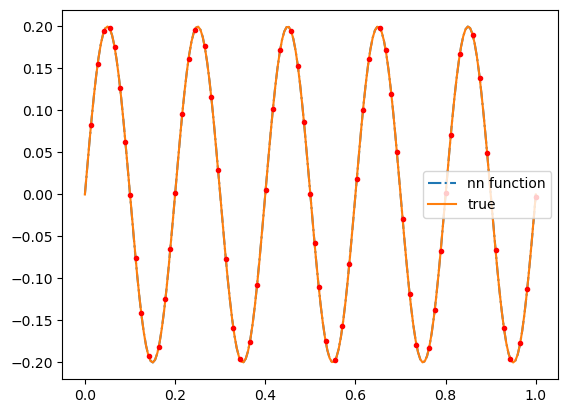

time taken:  3.0668327808380127
neuron num 		 error 		 order
4 		 0.170071 		 * 		 4.329673 		 * 

8 		 0.114463 		 0.571256 		 3.143219 		 0.462015 

16 		 0.007218 		 3.987077 		 0.538679 		 2.544745 

32 		 0.001685 		 2.099252 		 0.210907 		 1.352818 

64 		 0.000131 		 3.680605 		 0.042544 		 2.309563 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.170071 &		 * & 		 4.329673 & 		 *  \\ \hline  

8 		 &  1.145e-01 &  		 0.57 &  		 3.143e+00 &  		 0.46 \\ \hline  

16 		 &  7.218e-03 &  		 3.99 &  		 5.387e-01 &  		 2.54 \\ \hline  

32 		 &  1.685e-03 &  		 2.10 &  		 2.109e-01 &  		 1.35 \\ \hline  

64 		 &  1.314e-04 &  		 3.68 &  		 4.254e-02 &  		 2.31 \\ \hline  



In [15]:
def u_exact(x):
    return  0.2 * torch.sin(10*pi*x)

def du_exact(x):
    return  0.2 * 10*pi*torch.cos(10*pi*x) 

def laplacian_u_exact(x):
    return - 0.2 * (10*pi)**2 * torch.sin(10*pi*x)
def rhs(x):
    return   -laplacian_u_exact(x) + u_exact(x)  

def g_N(x):
    return du_exact(x) 

function_name = "sine1d" 
filename_write = "1DRandCGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "w")
f_write.write("\n")
f_write.close() 

save = False 

for N in [2**11]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**12
    order = 2  
    exponent = 6
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    rand_deter = 'deter' 
    err_QMC2, err_h10, my_model = OGANeumannReLU1D(None,rhs,u_exact,du_exact,g_N, N,num_epochs,plot_freq, Nx, order, k =2, rand_deter = rand_deter,solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    
    show_convergence_order(err_QMC2,err_h10,exponent,2*N,filename_write,True)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)

    